In [1]:
import os
import csv
import numpy as np
import pandas as pd
import sklearn
import pyod
import matplotlib.pyplot as plt
import time
import collections

In [2]:
from scipy import interpolate
from sklearn import metrics
from sklearn.decomposition import PCA, KernelPCA
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.utils.utility import standardizer
from pyod.models.pca import PCA
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.abod import ABOD
from pyod.models.loda import LODA
from pyod.models.lscp import LSCP
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification

/home/nick/Documents/python_venv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# 获取异常点比例

In [3]:
data = pd.read_csv('meta_data/meta_wine.csv')
data.head(10)

,bench.id,benchnum,origin,mset,size,n.anom,n.norm,anomaly.rate.level,point.difficulty.level,clustering.algo,irrelevance.level,anomaly.rate,diff.mean,anom.diff.mean,norm.diff.mean,clusteredness.score,irrelevance.score,auc.ci.0.999,ap.ci.0.999
0,wine_benchmark_0001,1,regression,wine,3703,1334,2369,ar-0,pd-0,none,ir-0,0.360248,0.182961,0.261760,0.138589,-0.166763,0.000000,0.524572,0.387671
1,wine_benchmark_0002,2,regression,wine,3703,1291,2412,ar-0,pd-0,none,ir-0,0.348636,0.183128,0.263461,0.140131,-0.143345,0.000000,0.524823,0.376016
2,wine_benchmark_0003,3,regression,wine,3703,1350,2353,ar-0,pd-0,none,ir-0,0.364569,0.183230,0.260720,0.138770,-0.130568,0.000000,0.524217,0.392040
3,wine_benchmark_0004,4,regression,wine,3703,1380,2323,ar-0,pd-0,none,ir-0,0.372671,0.184372,0.260923,0.138897,-0.121468,0.000000,0.524031,0.400212
4,wine_benchmark_0005,5,regression,wine,3703,1334,2369,ar-0,pd-0,none,ir-0,0.360248,0.181841,0.260440,0.137581,-0.113667,0.000000,0.524572,0.387671
5,wine_benchmark_0006,6,regression,wine,3703,1403,2300,ar-0,pd-0,none,ir-1,0.378882,0.187538,0.266665,0.139270,-0.143312,0.323806,0.523770,0.406464
6,wine_benchmark_0007,7,regression,wine,3703,1402,2301,ar-0,pd-0,none,ir-1,0.378612,0.186488,0.259993,0.141701,-0.136651,0.302566,0.523938,0.406059
7,wine_benchmark_0008,8,regression,wine,3703,1300,2403,ar-0,pd-0,none,ir-1,0.351067,0.182933,0.267649,0.137102,-0.134169,0.316460,0.524779,0.378546
8,wine_benchmark_0009,9,regression,wine,3703,1364,2339,ar-0,pd-0,none,ir-1,0.368350,0.183332,0.262973,0.136888,-0.169270,0.303228,0.524066,0.396072
9,wine_benchmark_0010,10,regression,wine,3703,1345,2358,ar-0,pd-0,none,ir-1,0.363219,0.181611,0.258572,0.137712,-0.141733,0.314420,0.524341,0.390723


In [4]:
ar = data['anomaly.rate']
ar_level = data['anomaly.rate.level']

In [5]:
set(ar_level)

{'ar-0', 'ar-1', 'ar-2', 'ar-3', 'ar-4', 'ar-6'}

In [6]:
data_dict = collections.defaultdict(list)
for item in data.iterrows():
    data_dict[item[1]['anomaly.rate.level']].append(item[1]['bench.id'])
for item in data_dict:
    print(len(data_dict[item]))

300
180
190
180
180
180


In [7]:
ar_mean = [np.mean(ar[:300]), np.mean(ar[300:480]), np.mean(ar[480: 670]),
          np.mean(ar[670:850]), np.mean(ar[850:1030]), np.mean(ar[1030:1210])]
ar_mean

[0.4124346847223458,
 0.0011470909950932401,
 0.005120850079917088,
 0.010155581545633032,
 0.05007634308372426,
 0.10014734720861593]

如上所示，数据一共分为6个异常点比例等级

# 查看其中一个数据，选择特征

In [8]:
data = pd.read_csv('benchmarks/wine_benchmark_0001.csv')
data.head(5)

,point.id,motherset,origin,original.label,diff.score,ground.truth,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol
0,wine_point_3594,wine,regression,7,0.050492,nominal,-1.245962,-0.362411,-0.265853,-0.261304,-0.343495,1.209882,0.747594,-0.899276,0.817846,-0.613338,0.174560
1,wine_point_5089,wine,regression,5,0.082237,anomaly,0.759540,0.973867,0.215849,-0.534540,0.598458,-0.536656,0.199134,0.968217,0.071518,0.596292,-0.915394
2,wine_point_1912,wine,regression,6,0.290201,nominal,-0.088942,-0.969809,-0.403482,-0.870829,-0.429127,-0.592996,-0.791633,-0.699187,-1.110168,1.402712,-0.496181
3,wine_point_4908,wine,regression,5,0.053559,anomaly,0.219597,0.973867,0.284664,0.138039,0.427194,-0.762016,-0.243173,1.034913,0.817846,1.805921,0.006874
4,wine_point_2246,wine,regression,7,0.420300,nominal,0.219597,-0.180191,-0.541112,0.348220,-0.714567,-0.142276,0.446826,-0.242318,-0.363840,-1.016548,0.090717


In [9]:
data.columns

Index(['point.id', 'motherset', 'origin', 'original.label', 'diff.score',
       'ground.truth', 'fixed.acidity', 'volatile.acidity', 'citric.acid',
       'residual.sugar', 'chlorides', 'free.sulfur.dioxide',
       'total.sulfur.dioxide', 'density', 'pH', 'sulphates', 'alcohol'],
      dtype='object')

## 以'fixed.acidity', 'volatile.acidity', 'citric.acid', 'residual.sugar', 'chlorides', 'free.sulfur.dioxide', 'total.sulfur.dioxide', 'density', 'pH', 'sulphates', 'alcohol'为特征

In [18]:
def evaluation(y, y_scores, method):
    if isinstance(y_scores, dict):
        colors = ['r', 'g', 'b', '#FF1493', '#483D8B']
        plt.figure(figsize = (7, 7))
        i = 0
        for algo in y_scores:
            pre_scr = y_scores[algo]
            print(algo, pre_scr.shape)
            fpr_level = np.arange(0, 1, 0.01)
            fpr, tpr, threshold = metrics.roc_curve(y, pre_scr)
            interp = interpolate.interp1d(fpr, tpr)
            tpr_at_fpr = [interp(x) for x in fpr_level]
            roc_auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr, color = colors[i], label = '%s ROC(area = %0.2f)'%(algo, roc_auc))
            i += 1
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('Models Compare' + '-ROC')
        plt.plot([0,1], [0,1], color = 'navy', linestyle = '--')
        plt.legend(loc = 'lower right')
    else:
        fpr_level = np.arange(0, 1, 0.01)
        fpr, tpr, threshold = metrics.roc_curve(y, y_scores)
        interp = interpolate.interp1d(fpr, tpr)
        tpr_at_fpr = [interp(x) for x in fpr_level]
        roc_auc = metrics.auc(fpr, tpr)
        precision, recall, _ = metrics.precision_recall_curve(y, y_scores)
        pr_auc = round(precision_n_scores(y, y_scores), ndigits=4)
        plt.figure(figsize=(12,5))
        plt.subplot(1, 2, 1)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title(method + '-ROC')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.plot(fpr, tpr, color='r', label='ROC curve (area = %0.2f)' % roc_auc)
        plt.legend(loc="lower right")
        plt.subplot(1, 2, 2)
        plt.plot(recall, precision, marker='.', label='precision @ rank n: %0.2f)' % pr_auc)
        plt.legend(loc="upper right")
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(method + '-PR')
        plt.show()

# 对原始数据抽样，每个异常点level选择一个benchmark

In [11]:
path = './benchmarks'
samples = []
for item in data_dict:
    samples.append(data_dict[item][0])
y = []
x_train = []
contam = 0
for sample in samples:
    file_path = os.path.join(path, sample + '.csv')
    data = pd.read_csv(file_path)
    data = data.dropna()
    for i in data.iterrows():
        if i[1][5] == 'anomaly':
            y.append(1)
            contam += 1
        else:
            y.append(0)
        x_train.append(list(i[1][6:17]))
x_train = np.array(x_train)
y = np.array(y)
contam /= len(y)
contam

0.08751529987760098

# 在抽样集合中进行离群点检测

In [12]:
algorithms = ['KNN', 'PCA', 'LOF', 'PCA + KNN']
all_scores = {}

## 1.KNN

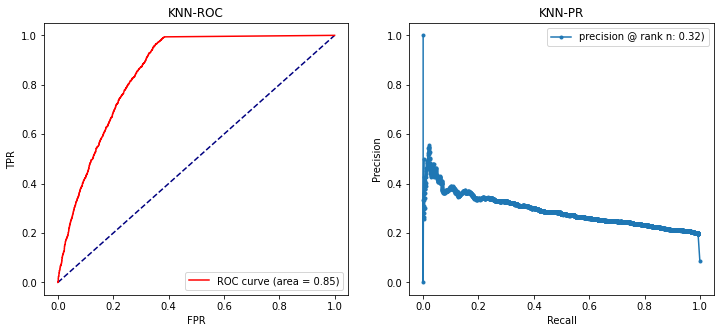

In [13]:
clf_name = 'KNN'
clf = KNN(n_neighbors = 5, contamination = contam)
x_train = standardizer(x_train)
clf.fit(x_train)
knn_y_pred = clf.labels_
knn_y_scores = clf.decision_scores_
evaluation(y, knn_y_scores, clf_name)
all_scores['KNN'] = knn_y_scores

## 2.PCA

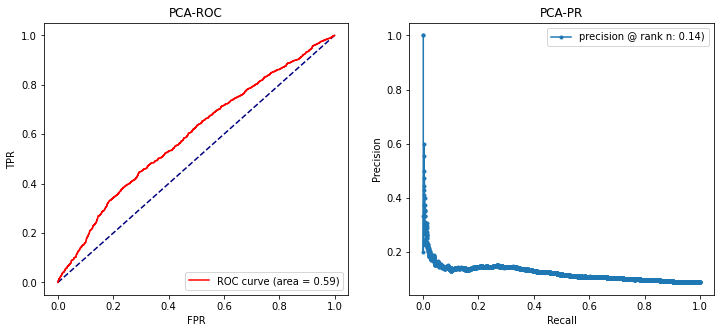

In [14]:
clf_name = 'PCA'
clf = PCA(contamination=contam)
x_train = standardizer(x_train)
clf.fit(x_train)
y_pred = clf.labels_  
y_scores = clf.decision_scores_
evaluation(y, y_scores, clf_name)
all_scores['PCA'] = y_scores

## 3.LOF

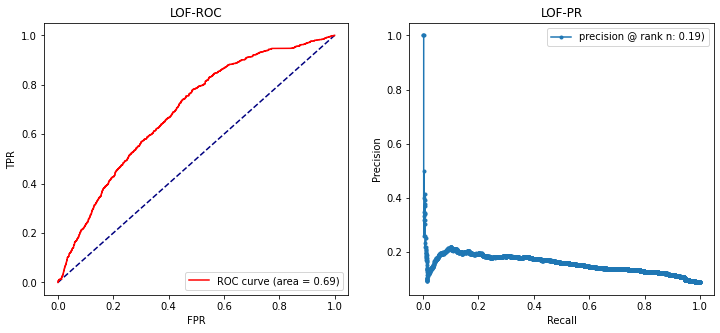

In [15]:
clf_name = 'LOF'
clf = LOF(contamination=contam)
x_train = standardizer(x_train)
clf.fit(x_train)
y_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_scores = clf.decision_scores_  # raw outlier scores
evaluation(y, y_scores, clf_name)
all_scores['LOF'] = y_scores

## 4.PCA+KNN

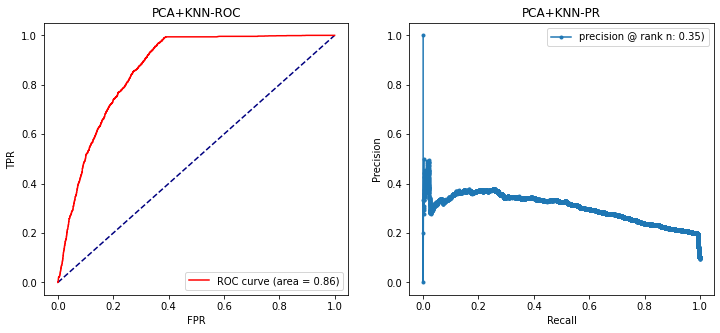

In [16]:
pca = PCA(n_components = 2)
kpca = KernelPCA(n_components = 2, kernel = 'poly')
x_train_pca = kpca.fit_transform(x_train)
clf = KNN(n_neighbors = 5, contamination = contam)
x_train_pca = standardizer(x_train_pca)
clf.fit(x_train_pca)
y_pred_pca = clf.labels_
y_scores = clf.decision_scores_
evaluation(y, y_scores, 'PCA+KNN')
all_scores['PCA+KNN'] = y_scores

KNN (22876,)
PCA (22876,)
LOF (22876,)
PCA+KNN (22876,)


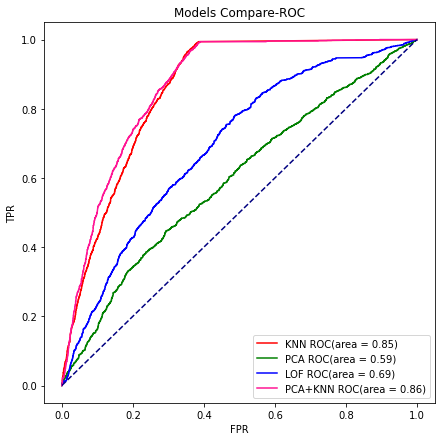

In [19]:
evaluation(y, all_scores, algorithms)

### 从图中可以看出，PCA+KNN和KNN在抽样数据中效果最好，而PCA表现最差。